# "CNNs: perros y gatos con Data augmentation"
> (SPANISH) Resolucion de la competicion Kaggle de lenguaje de signos 


- toc: true 
- badges: true 
- comments: true
- categories: ["Computer Vision"]
- image: images/kaggle.png

In [ ]:
# Introducción
Se va a resolver la competición de Kaggle expuesta [aqui](https://www.kaggle.com/c/dogs-vs-cats/data).
Se usarán 25,000 imágenes de perros y gatos.

In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
!kaggle competitions download -c dogs-vs-cats
#shutil.rmtree('/tmp')

#local_zip = path_cats_and_dogs
#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/tmp')
#zip_ref.close()


100%|████████████████████████████████████████| 812M/812M [14:52<00:00, 1.26MB/s]
100%|█████████████████████████████████████████| 812M/812M [14:52<00:00, 954kB/s]


In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 1500
# 1500

1500
1500


In [5]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.chdir('/tmp')
    os.mkdir('cats-v-dogs')
    os.mkdir('cats-v-dogs/training')
    os.mkdir('cats-v-dogs/testing')
    os.mkdir('cats-v-dogs/training/dogs')
    os.mkdir('cats-v-dogs/training/cats')
    os.mkdir('cats-v-dogs/testing/dogs')
    os.mkdir('cats-v-dogs/testing/cats')
except OSError:
    pass

In [6]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
# YOUR CODE STARTS HERE
    lista_ficheros = os.listdir(SOURCE)
    random.sample(lista_ficheros, len(lista_ficheros))
    lista_ficheros_training = lista_ficheros[:round(SPLIT_SIZE*len(lista_ficheros))]
    lista_ficheros_testing = lista_ficheros[round(SPLIT_SIZE*len(lista_ficheros)):]

    for fichero in lista_ficheros_training:
        if os.path.getsize(SOURCE+fichero)>0:
            copyfile(SOURCE+fichero, TRAINING+fichero)
    for fichero in lista_ficheros_testing:
        if os.path.getsize(SOURCE+fichero)>0:
            copyfile(SOURCE+fichero, TESTING+fichero)
# YOUR CODE ENDS HERE


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 1350
# 1350
# 150
# 150

1350
1350
150
150


In [8]:
# Usamos 3 capas convolucionales
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Aplanamos para entrar en una capa densa
    tf.keras.layers.Flatten(), 
    # 512 unidades
    tf.keras.layers.Dense(512, activation='relu'), 
    # activation sigmoid porque es una única salida (1 si gato, 0 si perro)
    tf.keras.layers.Dense(1, activation='sigmoid')  ])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

# NOTE:

In the cell below you **MUST** use a batch size of 10 (`batch_size=10`) for the `train_generator` and the `validation_generator`. Using a batch size greater than 10 will exceed memory limits on the Coursera platform.

In [9]:
TRAINING_DIR = '/tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator( rescale = 1.0/255. )

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(150, 150)) 

VALIDATION_DIR = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

# NOTE: YOU MUST USE A BACTH SIZE OF 10 (batch_size=10) FOR THE 
# VALIDATION GENERATOR.
validation_generator =  validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=10,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))



# Expected Output:
# Found 2700 images belonging to 2 classes.
# Found 300 images belonging to 2 classes.

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [11]:
history = model.fit_generator(train_generator,
                              epochs=2,
                              verbose=1,
                              validation_data=validation_generator)


Epoch 1/2
270/270 [==============================] - 41s 150ms/step - loss: 0.5252 - acc: 0.7322 - val_loss: 0.6337 - val_acc: 0.6700
Epoch 2/2
270/270 [==============================] - 40s 149ms/step - loss: 0.4512 - acc: 0.7930 - val_loss: 0.5766 - val_acc: 0.7333


Text(0.5, 1.0, 'Training and validation loss')

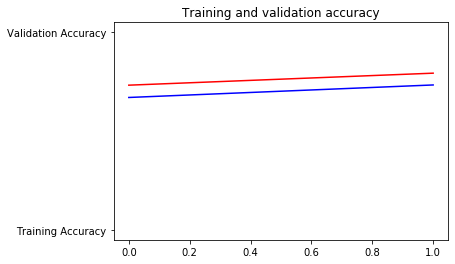

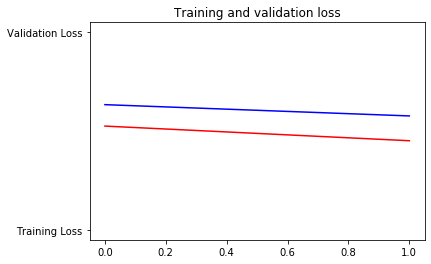

In [12]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)